# Thème: Classification d'images de cellules cancereuses et génération de données


## **Problématique:** Prédire la détection des cellules cancereuses.

## **Objectif:** Trouver la meilleure architecture de réseaux de neurones pour trouver le meilleur modèle.

# Source données: [data](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/CNN_model_dataset.zip)

In [ ]:
!pip install Pillow
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install seaborn
!pip install scikit-learn

In [ ]:
#Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

##Loading and Processing data

In [ ]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/CNN_model_dataset.zip

--2024-01-17 06:03:46--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/CNN_model_dataset.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.158.175, 52.219.158.127, 16.12.40.103, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.158.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170317173 (162M) [application/x-zip-compressed]
Saving to: ‘CNN_model_dataset.zip’

CNN_model_dataset.z 100%[===================>] 162.43M  13.7MB/s    in 14s     

2024-01-17 06:04:01 (11.7 MB/s) - ‘CNN_model_dataset.zip’ saved [170317173/170317173]



In [ ]:
from zipfile import ZipFile
file_name = "CNN_model_dataset.zip"
with ZipFile(file_name, 'r') as zip:
  zip.printdir()

  print('Extracting all the files now')
  zip.extractall()
  print('done!')

File Name                                             Modified             Size
data/test/                                     2021-07-19 09:48:14            0
data/test/benign/                              2021-07-19 09:48:14            0
data/test/benign/1.jpg                         2019-10-22 11:42:00        48625
data/test/benign/10.jpg                        2019-10-22 11:42:02        59249
data/test/benign/1003.jpg                      2019-10-22 11:42:02        55624
data/test/benign/1006.jpg                      2019-10-22 11:42:02        60733
data/test/benign/1013.jpg                      2019-10-22 11:42:02        47929
data/test/benign/1018.jpg                      2019-10-22 11:42:02        52462
data/test/benign/1019.jpg                      2019-10-22 11:42:02        61619
data/test/benign/1023.jpg                      2019-10-22 11:42:02        59080
data/test/benign/1025.jpg                      2019-10-22 11:42:04        53318
data/test/benign/1029.jpg               

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Loading data_train
data_train = "/content/data/train"
image_rep = Path(data_train)
# Get filepaths and labels
file_paths = list(image_rep.glob(r'**/*.JPG')) + list(image_rep.glob(r'**/*.jpg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths))

file_paths = pd.Series(file_paths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df_train = pd.concat([file_paths, labels], axis=1)

In [ ]:
image_df_train
print(image_df_train)

                                    Filepath      Label
0         /content/data/train/benign/530.jpg     benign
1         /content/data/train/benign/595.jpg     benign
2        /content/data/train/benign/1026.jpg     benign
3        /content/data/train/benign/1543.jpg     benign
4         /content/data/train/benign/750.jpg     benign
...                                      ...        ...
2632  /content/data/train/malignant/1470.jpg  malignant
2633   /content/data/train/malignant/907.jpg  malignant
2634  /content/data/train/malignant/1407.jpg  malignant
2635  /content/data/train/malignant/1466.jpg  malignant
2636  /content/data/train/malignant/1299.jpg  malignant

[2637 rows x 2 columns]


Les données d'entrainement sont constituées de 2637 observations et de 2 colonnes.

In [ ]:
#Loading data_test
data_test = "/content/data/test"
image_rep = Path(data_train)
# Get filepaths and labels
file_paths = list(image_rep.glob(r'**/*.JPG')) + list(image_rep.glob(r'**/*.jpg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths))

file_paths = pd.Series(file_paths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df_test = pd.concat([file_paths, labels], axis=1)

In [ ]:
image_df_test
print(image_df_test)

                                    Filepath      Label
0         /content/data/train/benign/530.jpg     benign
1         /content/data/train/benign/595.jpg     benign
2        /content/data/train/benign/1026.jpg     benign
3        /content/data/train/benign/1543.jpg     benign
4         /content/data/train/benign/750.jpg     benign
...                                      ...        ...
2632  /content/data/train/malignant/1470.jpg  malignant
2633   /content/data/train/malignant/907.jpg  malignant
2634  /content/data/train/malignant/1407.jpg  malignant
2635  /content/data/train/malignant/1466.jpg  malignant
2636  /content/data/train/malignant/1299.jpg  malignant

[2637 rows x 2 columns]


Les données de test sont constituées de 2637 enregistrements et de 2 colonnes.

In [ ]:
# Nettoyage des erreurs images
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("/content/data/train").rglob("*.jpg")
for img_p in path:
  try:
    img = PIL.Image.open(img_p)
  except PIL.UnidentifiedImageError:
    print(img_p)

## Aperçu d'un échantillon d'images

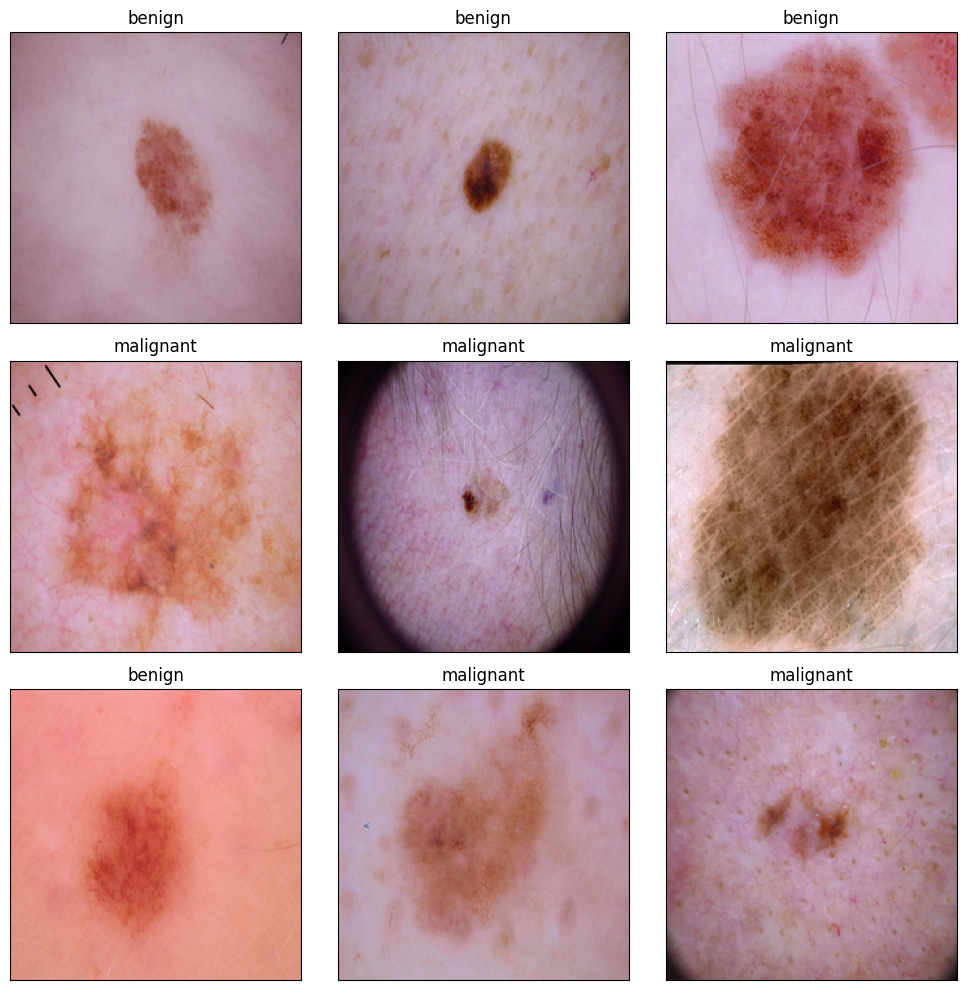

In [ ]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df_train), 10)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(image_df_train.Filepath[random_index[i]]))
  ax.set_title(image_df_train.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# Créer un générateur d'images pour la normalisation des données
datagen = ImageDataGenerator(rescale=1./255)

# Créer des générateurs à partir des train_data

train_generator = datagen.flow_from_directory(
    data_train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

test_generator = datagen.flow_from_directory(
    data_test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [ ]:
train_generator.image_shape


(224, 224, 3)

In [ ]:
print("Number of classes in train_generator:", train_generator.num_classes)
print("Number of classes in test_generator:", test_generator.num_classes)
print("Class indices in train_generator:", train_generator.class_indices)
print("Class indices in test_generator:", test_generator.class_indices)

Number of classes in train_generator: 2
Number of classes in test_generator: 2
Class indices in train_generator: {'benign': 0, 'malignant': 1}
Class indices in test_generator: {'benign': 0, 'malignant': 1}


## Architectures des réseaux de neurones

Pour notre modèle on va essayer de densifier les réseaux de neurones pour extraire le maximum d'informations (features) au niveau des images et avec des images de qualité en input.

In [ ]:
#Architecture du modèle
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())#Transformation des données d'entrées en un vecteur unidimensionnel
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(
  train_generator,
  validation_data=test_generator,
  epochs=10
)

Epoch 1/10
83/83 [==============================] - 391s 5s/step - loss: 0.6699 - accuracy: 0.6928 - val_loss: 0.4540 - val_accuracy: 0.7500
Epoch 2/10
83/83 [==============================] - 394s 5s/step - loss: 0.4441 - accuracy: 0.7759 - val_loss: 0.4292 - val_accuracy: 0.7894
Epoch 3/10
83/83 [==============================] - 376s 5s/step - loss: 0.4074 - accuracy: 0.8028 - val_loss: 0.3787 - val_accuracy: 0.7909
Epoch 4/10
83/83 [==============================] - 357s 4s/step - loss: 0.3797 - accuracy: 0.8066 - val_loss: 0.4866 - val_accuracy: 0.7561
Epoch 5/10
83/83 [==============================] - 360s 4s/step - loss: 0.3636 - accuracy: 0.8165 - val_loss: 0.3572 - val_accuracy: 0.8182
Epoch 6/10
83/83 [==============================] - 378s 5s/step - loss: 0.3410 - accuracy: 0.8354 - val_loss: 0.4006 - val_accuracy: 0.8061
Epoch 7/10
83/83 [==============================] - 358s 4s/step - loss: 0.3354 - accuracy: 0.8259 - val_loss: 0.4157 - val_accuracy: 0.7803
Epoch 8/10
83

<ipython-input-13-4f98bd36ea9c>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


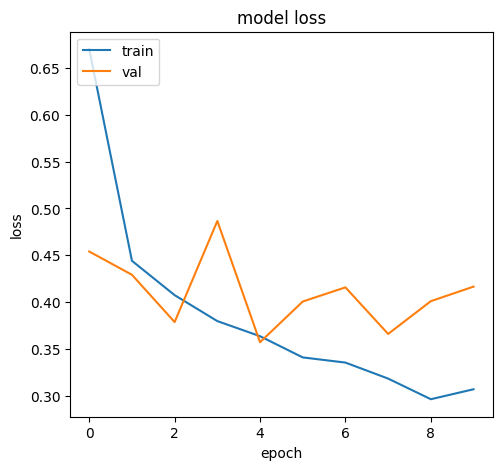

In [ ]:
#Accuracy and Loss
plt.figure(figsize = (12, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Pour notre premier modèle, on constate que la courbe de train loss diminue fortement indiquant une adaptation précise aux données d'entrainement. Donc on a un sur-ajustement (overfitting).

En constatant un surajustement (overfitting) de notre modèle, on va tenter de remédier à cela en appliquant un dropout après chaque connection complète. Donc 50% des connections sont supprimées pour le premier dropout et 30% pour le deuxième dropout. Et aussi augmenter le pool size (fenêtre de pooling couvre une région de 3x3 pixels).

![image.png](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2021/05/dropout-1024x253.png?lossy=2&strip=1&webp=1)

In [ ]:
#Architecture du modèle 1
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model1.add(layers.MaxPooling2D((3, 3)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((3, 3)))
model1.add(Dropout(0.5))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((3, 3)))
model1.add(layers.Flatten())#Transformation des données d'entrées en un vecteur unidimensionnel
model1.add(layers.Dense(128, activation='relu'))
model1.add(Dropout(0.3))
model1.add(layers.Dense(1, activation='sigmoid'))

# Compilation du modèle
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
history1 = model1.fit(
  train_generator,
  validation_data=test_generator,
  epochs=10
)

Epoch 1/10
83/83 [==============================] - 242s 3s/step - loss: 0.6453 - accuracy: 0.5927 - val_loss: 0.4837 - val_accuracy: 0.7727
Epoch 2/10
83/83 [==============================] - 233s 3s/step - loss: 0.4679 - accuracy: 0.7683 - val_loss: 0.4135 - val_accuracy: 0.7833
Epoch 3/10
83/83 [==============================] - 236s 3s/step - loss: 0.4397 - accuracy: 0.7854 - val_loss: 0.4921 - val_accuracy: 0.8045
Epoch 4/10
83/83 [==============================] - 231s 3s/step - loss: 0.4254 - accuracy: 0.7876 - val_loss: 0.3764 - val_accuracy: 0.8167
Epoch 5/10
83/83 [==============================] - 235s 3s/step - loss: 0.4362 - accuracy: 0.7869 - val_loss: 0.3816 - val_accuracy: 0.8030
Epoch 6/10
83/83 [==============================] - 238s 3s/step - loss: 0.3888 - accuracy: 0.8051 - val_loss: 0.3892 - val_accuracy: 0.8121
Epoch 7/10
83/83 [==============================] - 239s 3s/step - loss: 0.3945 - accuracy: 0.8100 - val_loss: 0.3662 - val_accuracy: 0.8348
Epoch 8/10
83

<ipython-input-16-f8a6eb240fd8>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


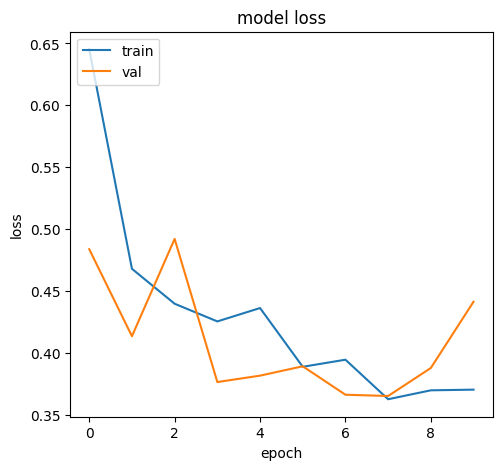

In [ ]:
#Accuracy and Loss
plt.figure(figsize = (12, 5))
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Sur ce graphe du modèle loss, on a plus de overfitting sur les données d'entrainement. Mais la qualité du loss sur les données de validation n'est pas bonne.

## Regularization L2/L1 :

En plus de Dropout, on va également utiliser la régularisation L2 sur les poids du modèle pour les maintenir à des valeurs relativement petites.



*   La régularisation L2 ajoute une pénalité à la somme des carrés des poids du modèle.
*   L'objectif est de maintenir les poids du modèle aussi petits que possible, ce qui aide à prévenir le surajustement.




In [ ]:
from tensorflow.keras import regularizers

#Architecture du modèle
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model2.add(layers.MaxPooling2D((3, 3)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((3, 3)))
model2.add(Dropout(0.5))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((3, 3)))
model2.add(layers.Flatten())#Transformation des données d'entrées en un vecteur unidimensionnel
model2.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dropout(0.3))
model2.add(layers.Dense(1, activation='sigmoid'))

# Compilation du modèle
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(
  train_generator,
  validation_data=test_generator,
  epochs=10
)

Epoch 1/10
83/83 [==============================] - 231s 3s/step - loss: 1.2936 - accuracy: 0.5673 - val_loss: 0.6138 - val_accuracy: 0.6939
Epoch 2/10
83/83 [==============================] - 223s 3s/step - loss: 0.6089 - accuracy: 0.7072 - val_loss: 0.5024 - val_accuracy: 0.7455
Epoch 3/10
83/83 [==============================] - 226s 3s/step - loss: 0.4661 - accuracy: 0.7793 - val_loss: 0.4244 - val_accuracy: 0.7985
Epoch 4/10
83/83 [==============================] - 220s 3s/step - loss: 0.4497 - accuracy: 0.7918 - val_loss: 0.4044 - val_accuracy: 0.7985
Epoch 5/10
83/83 [==============================] - 225s 3s/step - loss: 0.4382 - accuracy: 0.7922 - val_loss: 0.4141 - val_accuracy: 0.8167
Epoch 6/10
83/83 [==============================] - 220s 3s/step - loss: 0.4287 - accuracy: 0.8051 - val_loss: 0.4351 - val_accuracy: 0.8212
Epoch 7/10
83/83 [==============================] - 226s 3s/step - loss: 0.4273 - accuracy: 0.8096 - val_loss: 0.4088 - val_accuracy: 0.8258
Epoch 8/10
83

<ipython-input-19-2287f70aa354>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


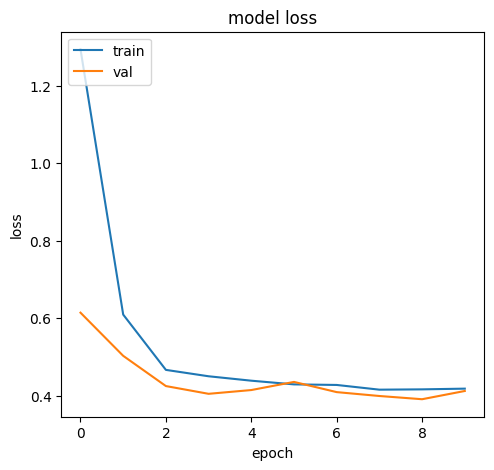

In [ ]:
#Accuracy and Loss
plt.figure(figsize = (12, 5))
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Dans ce modèle 2, le train loss montre que le modèle est bien entrainé.
* la courbe du validation loss à tendance à suivre la courbe train
* un meilleur modèle qui est capable de généraliser sur les données de validation.

## Conclusion
Le modèle 2 est plutôt de meilleure qualité en fonction de l'augmentation des epochs. Et on peut dire que l'on a un GoodFit. Avec une accuracy égale à 0.81.